In [1]:
from sklearn.utils.fixes import sklearn
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import string
import nltk
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
from collections import Counter
from nltk.corpus import stopwords
!pip install circlify
import circlify
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#load data
Data=pd.read_csv("Data.csv")
Data.head()

,Unique_ID,Category,Review_Header,Review_text,Rating,Own_Rating
0,136040,smartTv,Nice one,I liked it,5,Positive
1,134236,mobile,Huge battery life with amazing display,I bought the phone on Amazon and been using my...,5,Positive
2,113945,books,Four Stars,"Awesome book at reasonable price, must buy ......",4,Positive
3,168076,smartTv,Nice quality,good,5,Positive
4,157302,books,Nice book,"The book is fine,not bad,contains nice concept...",3,Neutral


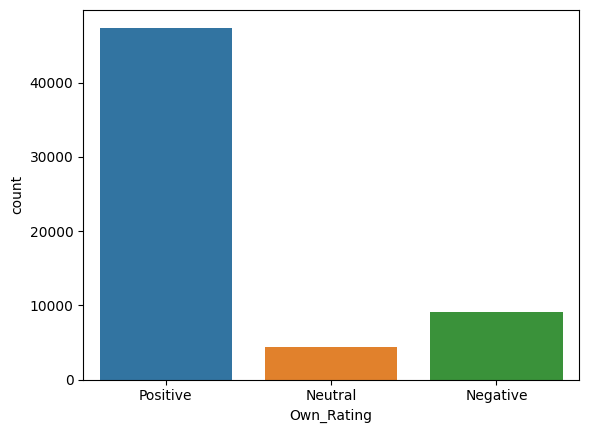

In [3]:
#visualizing data, seeing number of positive and negative
ax=sns.countplot(x='Own_Rating',data=Data)

# <b> Data Cleaning</b>

In [4]:
from numpy import NaN
# RemovingRemoving Punctuations, Numbers, and Special Characters

#Removing special characters
Data['Review_text'] = Data['Review_text'].str.replace("[^a-zA-Z# ]" ," ")
#Removing hash Tags
Data['Review_text'] = Data['Review_text'].str.replace("#", " ")
#Removing square brackets
Data['Review_text'] = Data['Review_text'].str.replace("\[[^]]*\]"," ")
#Removing punctuation marks
Data['Review_text'] =Data['Review_text'].str.translate(str.maketrans(" "," ",string.punctuation))



#Removing rows with neutral rating
Data = Data.drop(Data[Data['Own_Rating']=='Neutral'].index)
new_data = Data.loc[:, ['Own_Rating', 'Review_text']]
new_data = new_data.dropna()
new_data

<ipython-input-4-c9483cdac42b>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  Data['Review_text'] = Data['Review_text'].str.replace("[^a-zA-Z# ]" ," ")
<ipython-input-4-c9483cdac42b>:9: FutureWarning: The default value of regex will change from True to False in a future version.
  Data['Review_text'] = Data['Review_text'].str.replace("\[[^]]*\]"," ")


,Own_Rating,Review_text
0,Positive,I liked it
1,Positive,I bought the phone on Amazon and been using my...
2,Positive,Awesome book at reasonable price must buy ...
3,Positive,good
5,Positive,Nice tv and pic quality good custmer srrvice ...
...,...,...
60882,Positive,Nice Watch
60883,Negative,mm jack is not supporting any kind of h...
60884,Positive,Ok
60885,Positive,Value for money using since more than month...


<b>TOKENIZATION: converting words in Review text to tokens</b>

In [5]:
#loading data
new_data['Review_text'] = new_data['Review_text'].fillna("").apply(lambda x: x.split())
new_data.head()

,Own_Rating,Review_text
0,Positive,"[I, liked, it]"
1,Positive,"[I, bought, the, phone, on, Amazon, and, been,..."
2,Positive,"[Awesome, book, at, reasonable, price, must, buy]"
3,Positive,[good]
5,Positive,"[Nice, tv, and, pic, quality, good, custmer, s..."


# Stemming

In [6]:
stemmer = SnowballStemmer('english')
new_data['Review_text']= new_data['Review_text'].apply(lambda x: [stemmer.stem(i) for i in x])
new_data['Review_text'].head()

0                                        [i, like, it]
1    [i, bought, the, phone, on, amazon, and, been,...
2         [awesom, book, at, reason, price, must, buy]
3                                               [good]
5    [nice, tv, and, pic, qualiti, good, custmer, s...
Name: Review_text, dtype: object

**Filtering Stop words**

In [7]:
#Removing Stop words
stop_words = set(stopwords.words('english'))
def filter(text):
  text=text
  return [word for word in text if word.lower() not in stop_words]
new_data['Review_text']=new_data['Review_text'].apply(filter)  
new_data.shape

(56496, 2)

# VISUALIZATION

In [8]:
#visualizing the top 100 words and their counts
words = []
for tokens in new_data['Review_text']:
    for word in tokens:
        words.append(word)
word_counts = Counter(words)

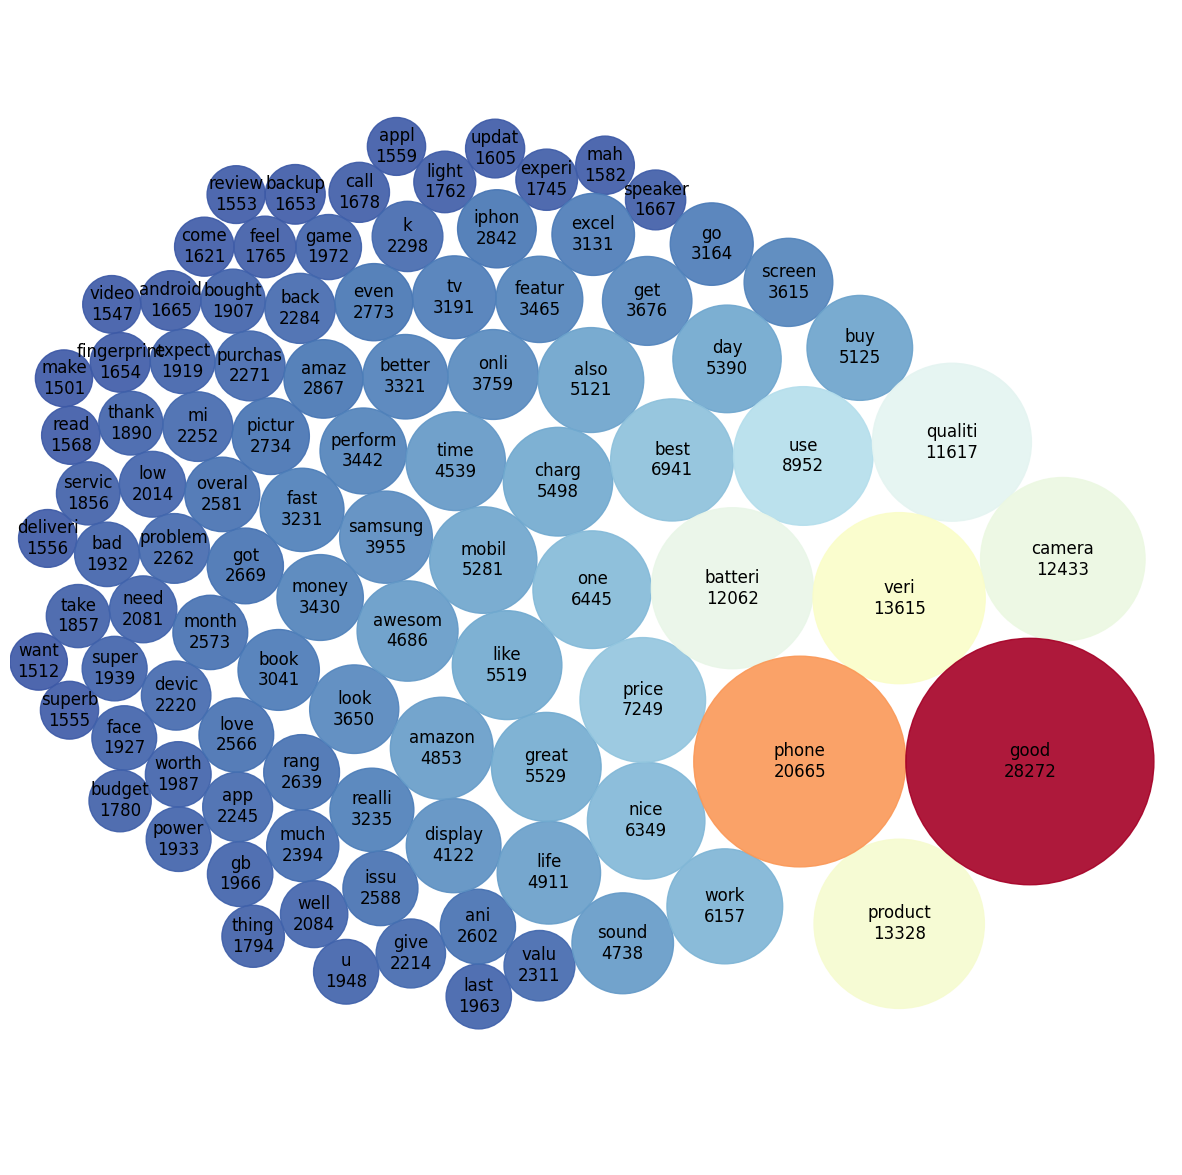

In [9]:
df =pd.DataFrame(list(word_counts.items()), columns=['words', 'count'])
df.sort_values('count', ascending=False, inplace=True)
df.reset_index(drop=True, inplace=True)
df

def get_colordict(palette,number,start):
    pal = list(sns.color_palette(palette=palette, n_colors=number).as_hex())
    color_d = dict(enumerate(pal, start=start))
    return color_d

circles = circlify.circlify(df['count'][0:100].tolist(), 
                            show_enclosure=False, 
                            target_enclosure=circlify.Circle(x=0, y=0)
                           )

n = df['count'].max()
color_dict = get_colordict('RdYlBu_r',n ,1)

fig, ax = plt.subplots(figsize=(15,15), facecolor='white')
ax.axis('off')
lim = max(max(abs(circle.x)+circle.r, abs(circle.y)+circle.r,) for circle in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# list of labels
labels = list(df['words'][0:100])
counts = list(df['count'][0:100])
labels.reverse()
counts.reverse()

for circle, label, count in zip(circles, labels, counts):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.9, color = color_dict.get(count)))
    plt.annotate(label +'\n'+ str(count), (x,y), size=12, va='center', ha='center')
plt.xticks([])
plt.yticks([])
plt.show()

# BAG OF WORDS

In [10]:
#Bag of words using TFIDF
X_train, X_test, Y_train, Y_test =train_test_split(new_data['Review_text'], new_data['Own_Rating'], test_size = 0.3,random_state=42,shuffle='True')
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
Y_train = Y_train[Y_train.notnull()]
X_train = X_train[X_train.notnull()]
X_train_flattened = [' '.join(review) for review in X_train]
X_test_flattened = [' '.join(review) for review in X_test]
X_train_counts = count_vect.fit_transform(X_train_flattened)
X_train_tfidf = transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test_flattened)
X_test_tfidf = transformer.transform(X_test_counts)
print(Y_train.unique())

['Negative' 'Positive']


## 5)*Training* the model

In [11]:
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight('balanced', classes=['Positive','Negative'],y=new_data['Own_Rating'])
class_weights=dict(zip(new_data['Own_Rating'].unique(),class_weights))
print(class_weights)
model = RandomForestClassifier(n_estimators=500,max_depth=10,class_weight=class_weights)
model.fit(X_train_tfidf,Y_train)
predictions = model.predict(X_test_tfidf)

{'Positive': 0.5958236658932715, 'Negative': 3.108958837772397}


In [12]:
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(Y_test,predictions)
f1_score(Y_test,predictions,average='macro')*100

83.19807761177196

In [13]:
new_review = "bad bad maintenance,bad food,good atmosphere"
new_review_counts = count_vect.transform([new_review])
new_review_tfidf = transformer.transform(new_review_counts)
new_rating = model.predict(new_review_tfidf)
print("The predicted rating for the new review is:" ,new_rating)

The predicted rating for the new review is: ['Positive']


# LSTM


In [14]:
from sklearn.preprocessing import LabelEncoder
#Encoding labels
reviews=new_data['Review_text'].values
rating=new_data['Own_Rating'].values
encoder=LabelEncoder()
new_data['Own_Rating']=encoder.fit_transform(new_data['Own_Rating'])
print(new_data['Own_Rating'])


0        1
1        1
2        1
3        1
5        1
        ..
60882    1
60883    0
60884    1
60885    1
60886    1
Name: Own_Rating, Length: 56496, dtype: int64


In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import keras
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import pad_sequences
import pandas as np

# from keras.util import pad_sequences
import keras
import nltk
                                                 

vocab_size = 4000
oov_tok = ''
embedding_dim = 100
max_length = 400 
padding_type='post'
trunc_type='post'
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
word_index = tokenizer.word_index


X_train, X_test, Y_train, Y_test =train_test_split(new_data['Review_text'],new_data['Own_Rating'] , test_size = 0.3,random_state=42,shuffle='True')
class_weights = compute_class_weight('balanced', classes=[1, 0],y=new_data['Own_Rating'])



# convert train dataset to sequence and pad sequences
tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)
# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

Y_train = encoder.fit_transform(Y_train)
Y_test = encoder.transform(Y_test)
X_train

33151    [veri, veri, poor, qualiti, product, phone, ev...
58745             [sound, qualiti, good, wire, veri, thin]
5332                                                [nice]
30525    [good, qualiti, good, sound, bass, good, good,...
56431                      [camera, best, profession, use]
                               ...                        
58559    [sound, qualiti, good, begin, month, purchas, ...
41105    [amazon, meet, expect, great, deal, great, pro...
927                                               [go, mi]
16987    [pretti, good, perform, phone, worth, price, u...
60810                          [must, mobil, money, vailu]
Name: Review_text, Length: 39547, dtype: object

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
max_features = 2000




model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(SpatialDropout1D(0.4))
# model.add(keras.layers.LSTM(128,dropout=0.4,return_sequences=True))
# model.add(keras.layers.LSTM(8,dropout=0.4,return_sequences=True))
model.add(keras.layers.LSTM(64,dropout=0.4,return_sequences=True))
model.add(keras.layers.LSTM(32,dropout=0.4))

model.add(keras.layers.Dense(1, activation='sigmoid',kernel_regularizer=keras.regularizers.l1(l=0.05)))

# compile
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()






Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 400, 100)          400000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 400, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 400, 64)           42240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 454,689
Trainable params: 454,689
Non-trainable params: 0
__________________________________________________

In [18]:
num_epochs = 15
from keras import callbacks
from keras.callbacks import EarlyStopping
class_weights = {i : class_weights[i] for i in range(len(class_weights))}
earlystopping=EarlyStopping(monitor="accuracy",mode="max",restore_best_weights=True,patience=2)

history = model.fit(train_padded,Y_train , epochs=num_epochs, verbose=1,validation_split=0.1,batch_size=20,class_weight=class_weights,callbacks=[earlystopping])

Epoch 1/15
1780/1780 [==============================] - 125s 65ms/step - loss: 0.5724 - accuracy: 0.8409 - val_loss: 0.6142 - val_accuracy: 0.8417
Epoch 2/15
1780/1780 [==============================] - 69s 39ms/step - loss: 0.5062 - accuracy: 0.8413 - val_loss: 0.5563 - val_accuracy: 0.8417
Epoch 3/15
1780/1780 [==============================] - 52s 29ms/step - loss: 0.4543 - accuracy: 0.8413 - val_loss: 0.5269 - val_accuracy: 0.8417
Epoch 4/15
1780/1780 [==============================] - 90s 51ms/step - loss: 0.4152 - accuracy: 0.8413 - val_loss: 0.5553 - val_accuracy: 0.8417


In [19]:
from sklearn.metrics import f1_score
prediction = model.predict(test_padded)
# Get labels based on probability 1 if p>= 0.5 else 0
pred_labels = []
for i in prediction:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)


530/530 [==============================] - 7s 12ms/step


In [20]:
print("Accuracy of prediction on test set : ", f1_score(Y_test,pred_labels)*100)

Accuracy of prediction on test set :  90.96114256304683


In [21]:
new_review = "bad qulality bad service"
sequences = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(sequences, maxlen=max_length)


prediction = model.predict(padded)
for i in prediction:
  if i >= 0.5:
        pred_labels.append(1)
  else:
        pred_labels.append(0)
for i in range(len(new_review)):
    if pred_labels[i] == 1:
        s = 'Positive'
    else:
        s = 'Negative'
s


1/1 [==============================] - 0s 31ms/step


'Positive'

# **UPSAMPLING** 

In [23]:
from sklearn.utils import shuffle
class_positive=new_data[new_data['Own_Rating']==1]
class_negative=new_data[new_data['Own_Rating']==0]
bias = class_negative.shape[0]/class_positive.shape[0]
train = pd.concat([class_positive.sample(frac=0.8,random_state=42),class_negative.sample(frac=0.8,random_state=42)])
test = pd.concat([class_positive.drop(class_positive.sample(frac=0.8,random_state=42).index),
        class_negative.drop(class_negative.sample(frac=0.8,random_state=42).index)])
train = shuffle(train)
test = shuffle(test)

In [24]:
from sklearn.utils import resample
class_positive=new_data[new_data['Own_Rating']==1]
class_negative=new_data[new_data['Own_Rating']==0]
data_minority_upsampled = resample(class_negative, replace=True,n_samples= class_positive.shape[0],random_state=123)
data_upsampled = pd.concat([class_positive, data_minority_upsampled])

# **upsampled RandomForest** 

In [25]:
#UPsampled RandomForest
X_train, X_test, Y_train, Y_test =train_test_split(data_upsampled['Review_text'], data_upsampled['Own_Rating'], test_size = 0.3,random_state=42,shuffle='True')
count_vect = CountVectorizer(stop_words='english')
transformer = TfidfTransformer(norm='l2',sublinear_tf=True)
Y_train = Y_train[Y_train.notnull()]
X_train = X_train[X_train.notnull()]
X_train_flattened = [' '.join(review) for review in X_train]
X_test_flattened = [' '.join(review) for review in X_test]
X_train_counts = count_vect.fit_transform(X_train_flattened)
X_train_tfidf = transformer.fit_transform(X_train_counts)
X_test_counts = count_vect.transform(X_test_flattened)
X_test_tfidf = transformer.transform(X_test_counts)
print(Y_train.unique())

[0 1]


In [26]:
#upsampled RandomForest
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight('balanced', classes=[1,0],y=data_upsampled['Own_Rating'])
class_weights=dict(zip(data_upsampled['Own_Rating'].unique(),class_weights))
print(class_weights)
model = RandomForestClassifier(n_estimators=200,max_depth=10,class_weight=class_weights)
model.fit(X_train_tfidf,Y_train)
predictions = model.predict(X_test_tfidf)

{1: 1.0, 0: 1.0}


# UpSampled RandomForest

In [27]:
#Upsampled RF
from sklearn.metrics import confusion_matrix,f1_score
confusion_matrix(Y_test,predictions)
f1_score(Y_test,predictions,average='macro')*100

85.66840080614016

In [28]:
new_review = "good maintenance,bad food"
new_review_counts = count_vect.transform([new_review])
new_review_tfidf = transformer.transform(new_review_counts)
new_rating = model.predict(new_review_tfidf)
print("The predicted rating for the new review is:" ,new_rating)

The predicted rating for the new review is: [1]


# UpSampled LSTM

In [29]:
from keras.models import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
max_features = 2000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(new_data['Review_text'].values) 

X_train = tokenizer.texts_to_sequences(data_upsampled['Review_text'].values)
X_train = pad_sequences(X_train,maxlen=29)
Y_train = data_upsampled['Own_Rating'].values
print('x_train shape:',X_train.shape)

X_test = tokenizer.texts_to_sequences(test['Review_text'].values)
X_test = pad_sequences(X_test,maxlen=29)
Y_test = test['Own_Rating'].values

print("x_test shape", X_test.shape)

embed_dim = 130


from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Dropout
from keras.regularizers import l1

model = Sequential()
model.add(Embedding(max_features, embed_dim,input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(64, dropout=0.4,return_sequences=True))
model.add(LSTM(32, dropout=0.4))
model.add(Dense(1,activation='relu',kernel_regularizer=keras.regularizers.l1(l=0.05)))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


x_train shape: (94820, 29)
x_test shape (11299, 29)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 29, 130)           260000    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 29, 130)          0         
 lDropout1D)                                                     
                                                                 
 lstm_2 (LSTM)               (None, 29, 64)            49920     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 322,369
Trainable params: 322,369
Non-trainable params

In [30]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[1,0],y=data_upsampled['Own_Rating'])
class_weights=dict(zip(data_upsampled['Own_Rating'].unique(),class_weights))
print(class_weights)

{1: 1.0, 0: 1.0}


In [31]:


from sklearn.utils import compute_class_weight

num_epochs = 150
from keras import callbacks
from keras.callbacks import EarlyStopping


earlystopping=EarlyStopping(monitor="accuracy",mode="max",restore_best_weights=True,patience=2)

history = model.fit(X_train,Y_train , 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1,batch_size=150,class_weight=class_weights,callbacks=[earlystopping])


Epoch 1/150
569/569 [==============================] - 40s 61ms/step - loss: 0.6461 - accuracy: 0.8175 - val_loss: 0.4546 - val_accuracy: 0.8469
Epoch 2/150
569/569 [==============================] - 11s 19ms/step - loss: 0.4724 - accuracy: 0.8643 - val_loss: 0.4951 - val_accuracy: 0.8148
Epoch 3/150
569/569 [==============================] - 9s 15ms/step - loss: 0.3869 - accuracy: 0.8921 - val_loss: 0.3968 - val_accuracy: 0.8598
Epoch 4/150
569/569 [==============================] - 7s 13ms/step - loss: 0.3601 - accuracy: 0.8994 - val_loss: 0.3378 - val_accuracy: 0.8683
Epoch 5/150
569/569 [==============================] - 7s 12ms/step - loss: 0.3141 - accuracy: 0.9063 - val_loss: 0.3257 - val_accuracy: 0.8879
Epoch 6/150
569/569 [==============================] - 6s 11ms/step - loss: 0.3069 - accuracy: 0.9094 - val_loss: 0.2148 - val_accuracy: 0.9176
Epoch 7/150
569/569 [==============================] - 5s 9ms/step - loss: 0.3021 - accuracy: 0.9142 - val_loss: 0.3413 - val_accuracy

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np

from sklearn.preprocessing import LabelEncoder
#Encoding labels
reviews=new_data['Review_text'].values
rating=new_data['Own_Rating'].values
encoder=LabelEncoder()
encoded_reviews=encoder.fit_transform(Y_test)
from sklearn.metrics import f1_score

# Get predicted classes
Y_pred = model.predict(X_test)

pred_labels = []
for i in Y_pred:
    if i >= 0.5:
        pred_labels.append(1)
    else:
        pred_labels.append(0)






f1 = f1_score(Y_test, pred_labels, average='binary')
print('F1 score:', f1)



print(classification_report(encoded_reviews, pred_labels))










[1 1 1 ... 1 1 1]
354/354 [==============================] - 2s 4ms/step
[[0.9674835 ]
 [0.9134315 ]
 [0.6650323 ]
 ...
 [0.93839693]
 [0.93921965]
 [0.94426   ]]
F1 score: 0.9781775601447733
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      1817
           1       0.99      0.97      0.98      9482

    accuracy                           0.96     11299
   macro avg       0.92      0.95      0.94     11299
weighted avg       0.97      0.96      0.96     11299



In [33]:
import numpy as np
twt = ["good look  bad quality"]

#vectorizing the tweet by the pre-fitted tokenizer instance
twt = tokenizer.texts_to_sequences(twt)
#padding the tweet to have exactly the same shape as `embedding_2` input
twt = pad_sequences(twt, maxlen=29, dtype='int32', value=0)

sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
for i in sentiment:
  if i>0.5:
    print('positive')
  else:
    print('Negative')


1/1 - 0s - 20ms/epoch - 20ms/step
positive
